<h3>Final Project Code: NB Supervised + Semisupervised for Emotions Analysis along with HDP-LDA for Topic Modelling. </h3>

<h5>Loading Data and Imports </h5>

In [1]:
#import modules
import pandas as pd
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from plotnine import ggplot, aes,labs, theme_bw, scale_x_continuous, \
                    geom_bar,lims, geom_text
import nltk
from tqdm import tqdm
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import tomotopy as tp
from sklearn.metrics import v_measure_score
import seaborn as sns
from sklearn.metrics import f1_score


In [2]:
# import data files for both models
train_set = pd.read_csv("./tests/data/tidy_text_data.csv")
train_set.head()
train_set = train_set[:1250]

extra_paragraphs = pd.read_csv("./tests/data/tidy_text_data.csv")
extra_paragraphs = extra_paragraphs[:1250]

train = pd.read_csv("./tests/data/train.txt", sep=";")
train.columns = ["text","sentiment"]
test = pd.read_csv("./tests/data/test.txt", sep=";")
test.columns = ["text","sentiment"]

In [32]:
# Helper functions
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def lemmatize(word_list, ptags):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    spC = spacy.load('en_core_web_sm')
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    return lem_lists

def clean_nonentry_lemmatized(df):
    list_to_remove = []
    for i, word_list in enumerate(df):
        if len(word_list) == 0:
            list_to_remove.append(i)
    list_to_remove.reverse()
    for index in list_to_remove:
        df.pop(index)
    return df

def breakdown_clusters_by_ground_truth(y_true, cluster_labels, display=True) :
    assert len(y_true) == len(cluster_labels), "Length of Target and cluster labels don't match"
    df = pd.DataFrame({'true topics' : y_true, 'predictions' : cluster_labels})
    counts = df.groupby(['true topics', 'predictions']).size().reset_index().rename(columns={0:'count'})
    if display :
        sns.barplot(x="true topics", y="count", hue="predictions", data=counts)
    return v_measure_score(y_true, cluster_labels)

def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
        topic_list.append(topic_tokens)
    # Build Coherence model
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    score = cm.get_coherence()
    return score

<h4> Preprocessing Data for Models </h4>

In [4]:
# Data Processing for Emotions NB
train_text = train.text
extra_paragraphs_text = extra_paragraphs.text_new
vectorizer = CountVectorizer(max_features=5000, min_df=3, binary=True, 
                             stop_words="english")
X_supervised = vectorizer.fit_transform(train_text)
X_unsupervised = vectorizer.transform(extra_paragraphs_text)
y_topic_train = train['sentiment']
y_topic_test = test['sentiment']
X_supervised.shape, X_unsupervised.shape
X = vectorizer.fit_transform(train_text)
X_test = vectorizer.transform(test.text)
test_sentiment = test.sentiment
combined_X = np.concatenate((X_supervised.toarray(), X_unsupervised.toarray()), axis = 0)
mask = np.arange(X_supervised.shape[0])
topics = unique(train['sentiment'])
y_train = np.array([topics.index(k) for k in train['sentiment']],dtype=int)
combined_Y = np.concatenate((y_train, np.zeros(X_unsupervised.shape[0], dtype=int)), axis=0)
y_test = np.array([topics.index(k) for k in test_sentiment],dtype=int)

print("Number of emotions: " + str(len(unique(combined_Y))))
n, d = X.shape
k = 6
X.shape
temp = np.zeros((len(y_train),k))
for i in range(n):
    temp[i,y_train[i]] = 1


Number of emotions: 6


In [5]:
# Data Processing for HDP-LDA topic modelling
# Remove stop words, minimum word length = 3, create bigrams, lemmatize words. 
nltk.download('stopwords', quiet=True)
st_words = stopwords.words('english')
extra_stops=['from','subject','re', 'edu','use']
st_words.extend(extra_stops)
doc_list = train_set.text_new.values.tolist()
word_list = [simple_preprocess(str(txt), deacc=True, min_len=3) for txt in doc_list]
bigram = Phrases(word_list, min_count=5, threshold=100) # use original wordlist to build model
bigram_model = Phraser(bigram)
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]
word_list_lemmatized = lemmatize(word_bigrams, ptags=['NOUN','VERB','ADV','ADJ'])

# Clean data
word_list_lemmatized = clean_nonentry_lemmatized(word_list_lemmatized)
print(word_list_lemmatized[0][:7],len(word_list_lemmatized[0]),len(word_list_lemmatized) )

['lean', 'empty', 'guard', 'desk', 'hear', 'footstep', 'straighten'] 15 1248


<h4>NB Supervised + Semisupervised Training for Emotions Analysis </h4>

In [6]:
class SoftMultinomialNB(MultinomialNB):
    # Note y = numpy array of size n x k containing 
    # for each example n, the probability of it belonging to class k.
    def fit(self, X, y, sample_weight=None):        
      _, n_features = X.shape
      self.n_features_in_ = n_features 
      Y = y
      self.classes_ = np.arange(Y.shape[1])
      
      if sample_weight is not None:
          Y = Y.astype(np.float64, copy=False)
          sample_weight = np.asarray(sample_weight)
          sample_weight = np.atleast_2d(sample_weight)
      class_prior = self.class_prior
      # Count raw events from data before updating the class log prior
      # and feature log probas
      n_effective_classes = Y.shape[1]
      self._init_counters(n_effective_classes, n_features)
      self._count(X, Y)
      alpha = self._check_alpha()
      self._update_feature_log_prob(alpha)
      self._update_class_log_prior(class_prior=class_prior)
      return self

# Semi supervised EM NB with soft and hard capabilities.
def semisupervised_EM(init_model,k, X, y_true, mask, max_iters=200, soft=False,
                      return_model=False):
    '''
    Implements semi-supervised Hard or Soft EM model.
        - init_model is a function for initializing the SoftMultinomialNB model
            (hint: you are going to want to use this parameter later in the
             homework to initialize in a different model)
        - X is an (n x d) numpy array
        - y_true - 0-6 class labels defined previously.
        - mask - an array of size n containing True or False indicating if you
            are to use the true labels of that example or not.
        - soft - a boolean variable, which if true, performs soft EM and
            otherwise performs hard EM
        - return_model - specifies whether or not to return the NB classifier
    '''
    X.shape
    temp = np.zeros((len(y_true),k))
    for i in range(temp.shape[0]):
        temp[i,y_true[i]] = 1
    # model init
    m = init_model()
    x_train = X[mask]
    # y_train = y_true[mask]
    y_train_mat = temp[mask]
    #fit training with masked train targets
    m.fit(x_train, y_train_mat)
    y_hat = None
    for _ in tqdm(range(max_iters)):
        # E Step: predict the latent variables (y_hat) using the model
        newy_hat = m.predict_proba(X)
        if not soft:
            for i_soft in range(len(newy_hat)):
                bestindex = np.argmax(newy_hat[i_soft])
                newy_hat[i_soft,:] = 0
                newy_hat[i_soft, bestindex] = 1
        # converged, return model
        if (newy_hat == y_hat).all():
            if return_model:
                return newy_hat, m
            else: 
                return newy_hat
        y_hat = newy_hat
        #M Step: retrain the model using the latent variables
        y_hat[mask] = y_train_mat
        m.fit(X, y_hat)
    y_hat = m.predict(X)
    if return_model:
        return y_hat, m
    else:
        return y_hat

<h4> NB Supervised + Semisupervised Model Training for Emotions Analysis </h4>

In [7]:
# train supervised, semi supervised softs and hards models
m_spvised = SoftMultinomialNB(fit_prior=False).fit(X, temp)
y_hat_spvised = m_spvised.predict(X_test)
yhat_soft, m_soft = semisupervised_EM(lambda: SoftMultinomialNB(), 6, combined_X, combined_Y, mask, return_model=True, soft=True)
yhat_hard, m_hard = semisupervised_EM(lambda: SoftMultinomialNB(), 6, combined_X, combined_Y, mask, return_model=True)

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


<h4>NB Supervised + Semisupervised Model Evaluation for Emotions Analysis </h4>

In [8]:
# V-measure and f1 scores for train sets for both Hard & Soft-EM models
prediction_train = m_soft.predict(X_supervised)
train_eval = v_measure_score(train.sentiment, prediction_train)
print(f'The f1 score of fully trained Soft-EM model = {f1_score(y_train, prediction_train,average="macro")}')
print(f'The v-measure of fully trained Soft-EM model = ' + str(train_eval))
print()
prediction_train_hard = m_hard.predict(X_supervised)
train_eval = v_measure_score(train.sentiment, prediction_train_hard)
print(f'The f1 score of fully trained Hard-EM model = {f1_score(y_train, prediction_train_hard,average="macro")}')
print(f'The v-measure of fully trained Hard-EM model = ' + str(train_eval))


The f1 score of fully trained Soft-EM model = 0.8880947429311116
The v-measure of fully trained Soft-EM model = 0.7669671920035445

The f1 score of fully trained Hard-EM model = 0.8937319788053512
The v-measure of fully trained Hard-EM model = 0.777863080032788


The f1 score of fully trained model = 0.7329266095376865
The v-measure of fully trained model = 0.5700987286997196


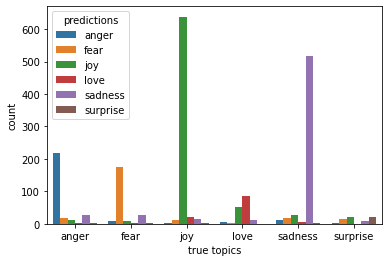

In [33]:
# Soft-EM Model Results on semi-supervised test set
prediction_test_soft = m_soft.predict(X_test)
predictions_emotions_soft = [topics[i] for i in prediction_test_soft]
test_eval_soft = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(test_sentiment, predictions_emotions_soft, d)
print(f'The f1 score of fully trained model = {f1_score(y_test, prediction_test_soft,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval_soft(prediction_test_soft, d=True)}')

The f1 score of fully trained model = 0.7429693433056285
The v-measure of fully trained model = 0.5893649307648582


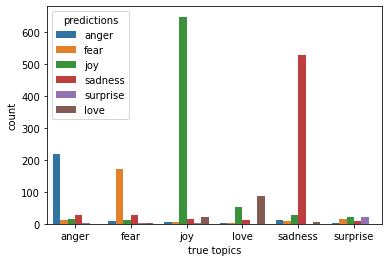

In [34]:
# Hard-EM Model Results on semi-supervised test set
prediction_test_hard = m_hard.predict(X_test)
predictions_emotions_hard = [topics[i] for i in prediction_test_hard]
test_eval_hard = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(test.sentiment, predictions_emotions_hard, d)
print(f'The f1 score of fully trained model = {f1_score(y_test, prediction_test_hard,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval_hard(prediction_test_hard, d=True)}')

The f1 score of fully trained model = 0.7806264577724985
The v-measure of fully trained model = 0.5971668515814397


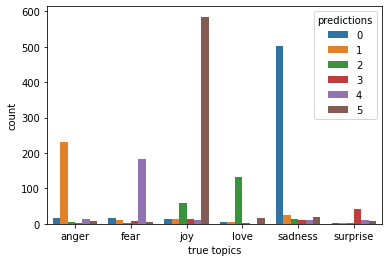

In [35]:
# Results for supervised model on test set
train_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(y_topic_train, cluster_labels, d)
test_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(y_topic_test, cluster_labels, d)

print(f'The f1 score of fully trained model = {f1_score(y_hat_spvised, y_test,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval(y_hat_spvised, d=True)}')

<h4> HDP-LDA Model Training for Topic Modelling </h4>

In [12]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)
        
    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
    print("Done\n")  
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [13]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

# train trainning data with all three tomotopy models
for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=2000)
    # save models
    hdp.save('./tests/models/hdp_model_'+tw_names[i]+".bin")
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Training...


Model one
Num docs: 1248 , Vocab size: 877 , Num words: 13406
Removed top words: ['know', 'time', 'make', 'day', 'see', 'life', 'come']
Iteration: 0	Log-likelihood: -6.930880882927469	Num. of topics: 242
Iteration: 200	Log-likelihood: -6.922614476351032	Num. of topics: 237
Iteration: 400	Log-likelihood: -6.926428708552816	Num. of topics: 251
Iteration: 600	Log-likelihood: -6.923550472657182	Num. of topics: 253
Iteration: 800	Log-likelihood: -6.909958163695639	Num. of topics: 256
Iteration: 1000	Log-likelihood: -6.905418902462176	Num. of topics: 224


Training...


Iteration: 1200	Log-likelihood: -6.911682220353985	Num. of topics: 253
Iteration: 1400	Log-likelihood: -6.89643735444921	Num. of topics: 244
Iteration: 1600	Log-likelihood: -6.918725563397465	Num. of topics: 247
Iteration: 1800	Log-likelihood: -6.887567784703349	Num. of topics: 231
Done

Model pmi
Num docs: 1248 , Vocab size: 877 , Num words: 13406
Removed top words: ['know', 'time', 'make', 'day', 'see', 'life', 'come']
Iteration: 0	Log-likelihood: -6.43160727719809	Num. of topics: 43
Iteration: 200	Log-likelihood: -6.400156239544435	Num. of topics: 50
Iteration: 400	Log-likelihood: -6.386461509555605	Num. of topics: 52
Iteration: 600	Log-likelihood: -6.434541662625401	Num. of topics: 38
Iteration: 800	Log-likelihood: -6.42785021320268	Num. of topics: 42
Iteration: 1000	Log-likelihood: -6.43788005597721	Num. of topics: 35
Iteration: 1200	Log-likelihood: -6.430936217516775	Num. of topics: 38
Iteration: 1400	Log-likelihood: -6.42171585452861	Num. of topics: 39

Training...



Iteration: 1600	Log-likelihood: -6.421117805225019	Num. of topics: 45
Iteration: 1800	Log-likelihood: -6.389301067910654	Num. of topics: 47
Done

Model idf
Num docs: 1248 , Vocab size: 877 , Num words: 13406
Removed top words: ['know', 'time', 'make', 'day', 'see', 'life', 'come']
Iteration: 0	Log-likelihood: -6.362968932823169	Num. of topics: 65
Iteration: 200	Log-likelihood: -6.35591060846559	Num. of topics: 59
Iteration: 400	Log-likelihood: -6.377029092849457	Num. of topics: 60
Iteration: 600	Log-likelihood: -6.417709312279949	Num. of topics: 50
Iteration: 800	Log-likelihood: -6.361771826512085	Num. of topics: 55
Iteration: 1000	Log-likelihood: -6.404408055826198	Num. of topics: 52
Iteration: 1200	Log-likelihood: -6.3959418195620685	Num. of topics: 58
Iteration: 1400	Log-likelihood: -6.438981240750642	Num. of topics: 43
Iteration: 1600	Log-likelihood: -6.3996610476985625	Num. of topics: 55
Iteration: 1800	Log-likelihood: -6.411403250886867	Num. of topics: 44
Done



<h4> HDP-LDA Model Evaluation for Topic Modelling </h4>

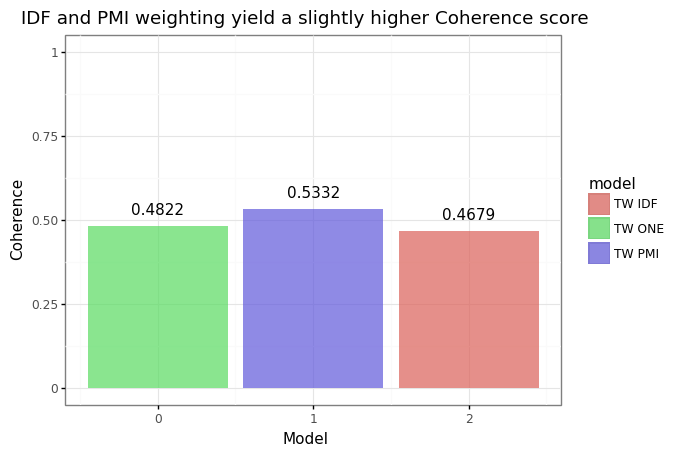

<ggplot: (105016520967)>

In [14]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)
    
# Plotting
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [15]:
# Load models
hdp_one = tp.HDPModel.load("./tests/models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("./tests/models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("./tests/models/hdp_model_idf.bin")

#Pulling top labels for potential topics and organize in df
topics_df = pd.DataFrame(columns=["entry", "lemmatized", "topic_id", "top_three_labels"])
for i in range(len(word_list_lemmatized)):
    test_doc = word_list_lemmatized[i]
    doc_init = hdp_idf.make_doc(test_doc)
    topic_dist, learned_labels = hdp_idf.infer(doc_init, together=True)
    topic_id = np.array(topic_dist).argmax()
    topic_freqs = dict(hdp_idf.get_topic_words(topic_id))
    topic_keys = list(topic_freqs.keys())
    top_topics = topic_keys[:8]
    to_append = [train_set.text_new[i], test_doc, str(topic_id), str(top_topics)]
    topics_df.loc[i] = to_append
topics_df.head
    

<bound method NDFrame.head of                                                   entry  \
0     James was leaning against the empty guard desk...   
1     There was no clock on the nightstand between t...   
2     Finley should’ve been happier — he should’ve b...   
3     Inside a Belizean cave, you wade deeper into g...   
4     Sophie had forgotten him by then. Not complete...   
...                                                 ...   
1243  He figured a few sticks of dynamite were easie...   
1244  With a single flip of the coin, his life chang...   
1245      Warm beer on a cold day isn't my idea of fun.   
1246  We have never been to Asia, nor have we visite...   
1247  The irony of the situation wasn't lost on anyo...   

                                             lemmatized topic_id  \
0     [lean, empty, guard, desk, hear, footstep, str...        7   
1     [nightstand, bed, analogue, phone, brochure, t...        7   
2     [happy, beam, hardwood, car, job, girlfriend, ...  

In [16]:
#decribe topics_df
def describe_topics_df(df, num):
    if num > df.shape[0]:
        print("document index is larger than df size.")
    else:
        print("Number of entries: " + str(len(df.entry)))
        print("Number of unique topics found in entries: " + str(len(unique(df.topic_id))))
        print()
        print("Example " + str(num) + " found text entry: '" + df.entry[num] + "' belongs to topic number " +  str(df.topic_id[num]) + " with top associted keywords: " + str(df.top_three_labels[num]))

#choose any random number
describe_topics_df(topics_df, 420)

Number of entries: 1248
Number of unique topics found in entries: 35

Example 420 found text entry: 'She had been an angel for coming up on 10 years and in all that time nobody had told her this was possible. The fact that it could ever happen never even entered her mind. Yet there she stood, with the undeniable evidence sitting on the ground before her. Angels could lose their wings.' belongs to topic number 7 with top associted keywords: ['take', 'look', 'want', 'think', 'go', 'way', 'get', 'never']


<h4> Emotions Analysis on Topics of Random Entries </h4>


In [21]:
text_entries = topics_df.entry
vectorized_text_entries = vectorizer.transform(text_entries)
numerical_predictions = m_hard.predict(vectorized_text_entries) 
emotions_predictions = [topics[i] for i in numerical_predictions]
topics_df["emotions"] = emotions_predictions
topics_df.emotions.head

topics_df.head


<bound method NDFrame.head of                                                   entry  \
0     James was leaning against the empty guard desk...   
1     There was no clock on the nightstand between t...   
2     Finley should’ve been happier — he should’ve b...   
3     Inside a Belizean cave, you wade deeper into g...   
4     Sophie had forgotten him by then. Not complete...   
...                                                 ...   
1243  He figured a few sticks of dynamite were easie...   
1244  With a single flip of the coin, his life chang...   
1245      Warm beer on a cold day isn't my idea of fun.   
1246  We have never been to Asia, nor have we visite...   
1247  The irony of the situation wasn't lost on anyo...   

                                             lemmatized topic_id  \
0     [lean, empty, guard, desk, hear, footstep, str...        7   
1     [nightstand, bed, analogue, phone, brochure, t...        7   
2     [happy, beam, hardwood, car, job, girlfriend, ...  

In [46]:
topics_emotions_analysis_df = pd.DataFrame()

def check_topic_with_dif_emotion(df):
    anger_count = 0
    fear_count = 0
    sadness_count = 0
    suprise_count = 0
    joy_count = 0
    love_count = 0
    
    for i in range(max(unique(df))):
        for j in range(len(df.topic_id)):
            if i != df.topic_id[j]:
                break
            else:
                if df.emotions[i] == "anger":
                    anger_count += 1
                elif df.emotions[i] == "love":
                    love_count += 1
                elif df.emotions[i] == "sadness":
                    sadness_count += 1
                elif df.emotions[i] == "suprise":
                    suprise_count += 1
                elif df.emotions[i] == "joy":
                    joy_count += 1
                elif df.emotions[i] == "fear":
                    fear_count += 1
                
check_topic_with_dif_emotion(topics_df, 7)
            
        

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [54]:
emotions_analysis = np.zeros((len(unique(topics_df.topic_id)), len(topics)))
print(unique(topics_df.topic_id))
for i in range(len(topics_df)):
    emotions_analysis[int(topics_df.topic_id[i]), topics.index(topics_df.emotions[i])] += 1

['7', '0', '34', '108', '19', '38', '30', '32', '35', '28', '37', '22', '40', '42', '3', '1', '20', '362', '9', '29', '6', '41', '2', '11', '10', '228', '26', '8', '36', '5', '51', '4', '62', '25', '21']


IndexError: index 108 is out of bounds for axis 0 with size 35